# **Homework 2**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Train and test data
train_data = train.data[:20000].float()
train_labels = train.targets[:20000]
test_data = test.data[:2000].float()
test_labels = test.targets[:2000]

# Normalization
train_data /= 255.0
test_data /= 255.0

# Adding bias
train_data = torch.cat((torch.ones(train_data.size(0), 1), train_data.view(train_data.size(0), -1)), 1)
test_data = torch.cat((torch.ones(test_data.size(0), 1), test_data.view(test_data.size(0), -1)), 1)

### **Part 2 : Perceptron**

In [3]:
# Perceptron
def train_perceptron(X, y, epochs=2, lr=100):
    weights = torch.zeros(X.size(1))
    for epoch in range(epochs):
        for i in range(X.size(0)):
            xi = X[i]
            yi = y[i]
            if yi * xi@weights <= 0:
                weights += lr * yi * xi
    return weights

# Training perceptrons
perceptron_models = []
for k in range(10):
    #print(f"Training perceptron for digit {k}")
    train_labels_k = (train_labels == k).float() * 2 - 1  # Convert labels to +1 or -1
    weights_k = train_perceptron(train_data, train_labels_k)
    perceptron_models.append(weights_k)

# Test accuracy
test_accuracies = []
for k, weights in enumerate(perceptron_models):
    test_labels_k = (test_labels == k).float() * 2 - 1  # Convert labels to +1 (digit k) or -1 (not digit k)
    predictions = test_data.matmul(weights) >= 0
    predictions = predictions.float() * 2 - 1  # Convert predictions to +1 or -1
    accuracy = (predictions == test_labels_k).float().mean().item()
    test_accuracies.append(accuracy)
    print(f"Test accuracy for digit {k}: {accuracy}")

Test accuracy for digit 0: 0.984499990940094
Test accuracy for digit 1: 0.9714999794960022
Test accuracy for digit 2: 0.9700000286102295
Test accuracy for digit 3: 0.9639999866485596
Test accuracy for digit 4: 0.9639999866485596
Test accuracy for digit 5: 0.9290000200271606
Test accuracy for digit 6: 0.9750000238418579
Test accuracy for digit 7: 0.9645000100135803
Test accuracy for digit 8: 0.921500027179718
Test accuracy for digit 9: 0.9419999718666077


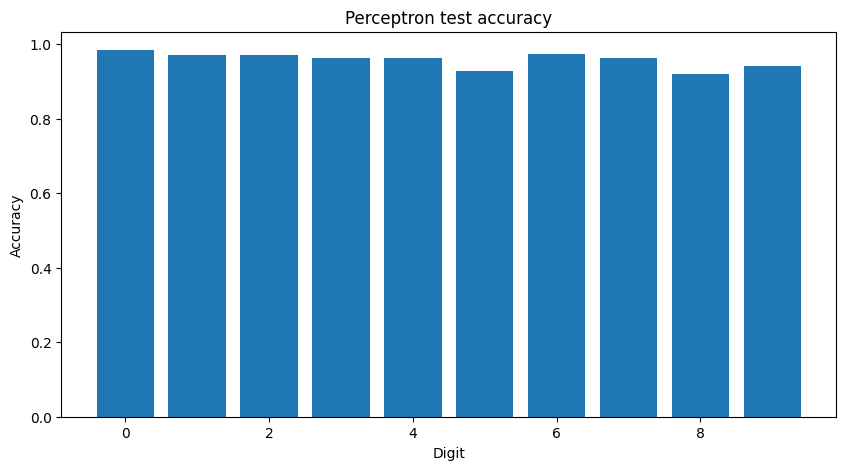

In [4]:
#plotting the accuracies
plt.figure(figsize=(10, 5))
plt.bar(range(10), test_accuracies)
plt.xlabel('Digit')
plt.ylabel('Accuracy')
plt.title('Perceptron test accuracy')
plt.show()

In [5]:
# Overall test accuracy
correct_predictions = 0
for i in range(len(test_data)):
    confidences = [test_data[i].matmul(weights).item() for weights in perceptron_models]
    predicted_digit = confidences.index(max(confidences))
    true_digit = test_labels[i].item()
    if predicted_digit == true_digit:
        correct_predictions += 1

overall_test_accuracy = correct_predictions / len(test_data)
print(f"Overall test accuracy: {overall_test_accuracy}")

Overall test accuracy: 0.849


### **Part 3: Logistic Regression**

In [6]:
# Defining the functions
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def compute_cost(X, y, theta):
    m = y.size(0)
    h = sigmoid(X @ theta)
    epsilon = 1e-5 # to prevent log(0)
    cost = -(1/m) * torch.sum(y * torch.log(h + epsilon) + (1 - y) * torch.log(1 - h + epsilon))
    return cost

def gradient_descent(X, y, theta, alpha, iterations):
    m = y.size(0)
    cost_history = np.zeros(iterations)

    for i in range(iterations):
        gradient = (1/m) * X.T @ (sigmoid(X @ theta) - y)
        theta -= alpha * gradient
        cost_history[i] = compute_cost(X, y, theta)

    return theta, cost_history

def compute_probabilities(X, theta):
    return sigmoid(X @ theta)

# Converting datasets to tensors 
train_data = train_data.clone().detach().float()
test_data = test_data.clone().detach().float()
train_labels = train_labels.clone().detach().int()
test_labels = test_labels.clone().detach().int()


#### (ii) 2-Way classifications

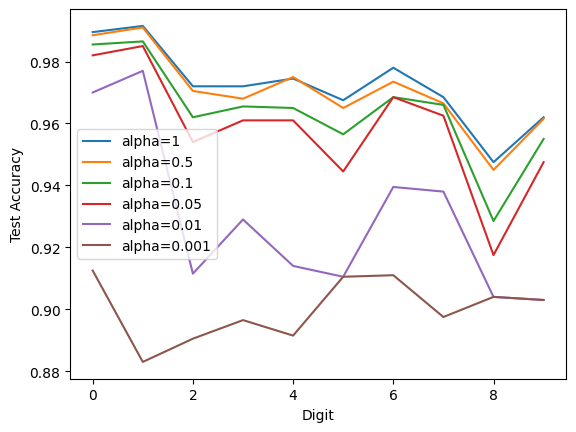

In [7]:
num_digits = 10
test_accuracies = np.zeros(num_digits)
alphas = [1,0.5,0.1,0.05,0.01, 0.001]
iterations = 300

for alpha in alphas:
    for k in range(num_digits):
        train_labels_k = (train_labels == k).float()
        test_labels_k = (test_labels == k).float()
        
        # Initialize the theta vector
        theta_k = torch.zeros(train_data.size(1), dtype=torch.float32)
        
        # Gradient descent
        theta_k, _ = gradient_descent(train_data, train_labels_k, theta_k, alpha, iterations)
        
        # Test accuracy
        test_predictions = sigmoid(test_data @ theta_k) >= 0.5
        test_accuracies[k] = (test_predictions.float() == test_labels_k).float().mean().item()

        #print(f"Test accuracy for digit {k} vs not {k}: {test_accuracies[k]:.4f}")
    plt.plot(np.arange(num_digits), test_accuracies,  label=f"alpha={alpha}")

plt.xlabel("Digit")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()

#### (iii) Overall test accuracy

Overall test accuracy for alpha = 1: 0.8785
Overall test accuracy for alpha = 0.5: 0.8765
Overall test accuracy for alpha = 0.1: 0.849
Overall test accuracy for alpha = 0.05: 0.8325
Overall test accuracy for alpha = 0.01: 0.7705


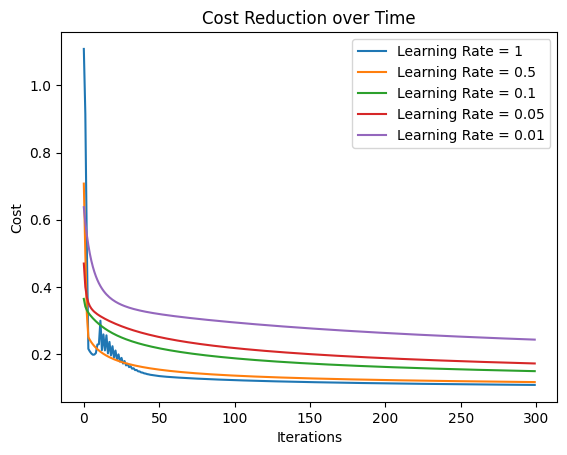

In [8]:
num_digits = 10
iterations = 300
alphas = [1,0.5,0.1,0.05,0.01]
accuracies = []

# Training the model
for alpha in alphas:
    test_probabilities = np.zeros((test_data.size(0), num_digits))
    
    # Model for each digit
    for k in range(num_digits):
        train_labels_k = (train_labels == k).float()
        theta_k = torch.zeros(train_data.size(1), dtype=torch.float32)
        theta_k, cost_history = gradient_descent(train_data, train_labels_k, theta_k, alpha, iterations)
        test_probabilities[:, k] = compute_probabilities(test_data, theta_k).detach().numpy().flatten()

    # Overall test accuracy
    predicted_labels = np.argmax(test_probabilities, axis=1)
    true_labels = test_labels.numpy()
    overall_test_accuracy = np.mean(predicted_labels == true_labels)

    print(f"Overall test accuracy for alpha = {alpha}: {overall_test_accuracy}")

    # Plotting the cost function
    plt.plot(cost_history, label = f'Learning Rate = {alpha}')
    accuracies.append(overall_test_accuracy)


plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost Reduction over Time')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Test accuracy vs Learning rate')

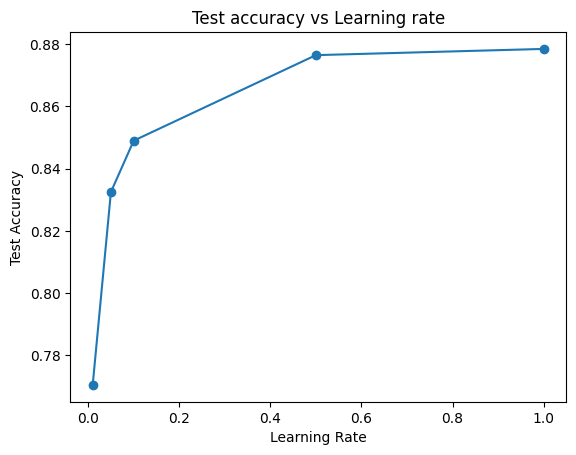

In [9]:
#Plotting accuracy vs alpha
plt.plot(alphas, accuracies, 'o-')
plt.ylabel("Test Accuracy")
plt.xlabel("Learning Rate")
plt.title("Test accuracy vs Learning rate")